In [1]:

import pandas as pd
from keras.src.callbacks import EarlyStopping
from sqlalchemy import and_, func
from sqlalchemy.exc import SQLAlchemyError

from etl.load.db import SessionLocal
from etl.load.models.diagnoses import Diagnosis
from etl.load.models.locations import Location
from etl.load.models.weather import Weather

session = SessionLocal()

# Diagnosis count per day around the world
query = (
    session.query(
        Weather.last_updated,
        (func.count(Diagnosis.id)).label("diagnosis_count"),
    )
    .join(
        Diagnosis,
        and_(
            Weather.temperature_category_id == Diagnosis.temperature_category_id,
        )
    )
    .join(Location,
          and_(
              Weather.location_id == Location.id,
              Location.name == "Budapest"
          )
          )
    .group_by(Weather.last_updated)
    .all()
)

# Convert the query result into a DataFrame
df = pd.DataFrame(query)

In [3]:
import numpy as np


def process_Xy(raw_X: np.array, raw_y: np.array, lookback: int) -> np.array:
    X = np.empty(shape=(raw_X.shape[0] - lookback, lookback, raw_X.shape[1]), dtype=np.float32)
    y = np.empty(shape=(raw_y.shape[0] - lookback), dtype=np.float32)

    target_index = 0
    for i in range(lookback, raw_X.shape[0]):
        X[target_index] = raw_X[i - lookback: i]
        y[target_index] = raw_y[i]
        target_index += 1

    return X.copy(), y.copy()

In [4]:
# Convert to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Set index
df.set_index('last_updated', inplace=True)


In [5]:
# Transform dates
df["Day.Of.Year.X"], df["Day.Of.Year.Y"] = np.sin(2 * np.pi * df.index.day_of_year / 365), np.cos(
    2 * np.pi * df.index.day_of_year / 365)

In [6]:
# Convert the column to float
df["diagnosis_count"] = df["diagnosis_count"].astype(float)

# Compute Q1 and Q3
Q1 = df["diagnosis_count"].quantile(0.25)
Q3 = df["diagnosis_count"].quantile(0.75)

# Compute Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df["diagnosis_count"].quantile(0.25)
Q3 = df["diagnosis_count"].quantile(0.75)

# Compute IQR
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df["diagnosis_count"] >= lower_bound) & (df["diagnosis_count"] <= upper_bound)]

In [7]:
# Set various data starting points
train_start = pd.Timestamp("2024-05-16")
valid_start = pd.Timestamp("2025-01-01")
test_start = pd.Timestamp("2025-04-01")
train_df = df[(df.index >= train_start) & (df.index < valid_start)].copy()
valid_df = df[(df.index >= valid_start) & (df.index < test_start)].copy()
test_df = df[(df.index >= test_start)].copy()

In [10]:
from sklearn.preprocessing import StandardScaler

# Scaling for target variables

scaler_input_count = StandardScaler()
scaler_output_count = StandardScaler()

scaled_train_count = scaler_input_count.fit_transform(train_df[["diagnosis_count"]])
target_train_count = scaler_output_count.fit_transform(train_df[["diagnosis_count"]])
scaled_valid_count = scaler_input_count.transform(valid_df[["diagnosis_count"]])
target_valid_count = scaler_output_count.transform(valid_df[["diagnosis_count"]])
scaled_test_count = scaler_input_count.transform(test_df[["diagnosis_count"]])
target_test_count = scaler_output_count.transform(test_df[["diagnosis_count"]])

In [11]:
# Set loopback for training, validation and testing

lookback = 10

train_X_count, train_y_count = process_Xy(scaled_train_count, target_train_count, lookback=lookback)
valid_X_count, valid_y_count = process_Xy(scaled_valid_count, target_valid_count, lookback=lookback)
test_X_count, test_y_count = process_Xy(scaled_test_count, target_test_count, lookback=lookback)

/var/folders/xt/zzc10tb96w34ttxv3r6_j17h0000gn/T/ipykernel_15890/3306726181.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[target_index] = raw_y[i]


In [12]:
from keras import Input
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model
model_count = keras.Sequential(
    [
        Input(shape=train_X_count.shape[1:]),
        layers.LSTM(16, activation="relu"),
        layers.Dense(1),
    ]
)  # Compile model
model_count.compile(loss='MeanSquaredError', optimizer='Adam')

# Summarize
model_count.summary()

# Callbacks
callbacks = [EarlyStopping(monitor="val_loss", patience=10)]

# Fitting the model
history_count = model_count.fit(
    train_X_count,
    train_y_count,
    validation_data=(valid_X_count, valid_y_count),
    batch_size=16,
    epochs=100,
    callbacks=callbacks,
    shuffle=True,
    verbose=False,
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,169 (4.57 KB)

 Trainable params: 1,169 (4.57 KB)

 Non-trainable params: 0 (0.00 B)

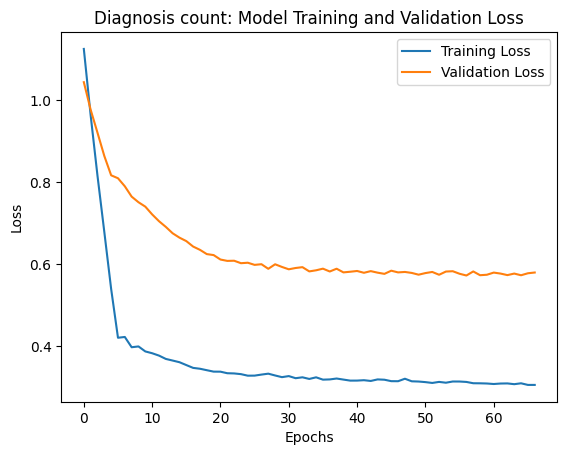

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


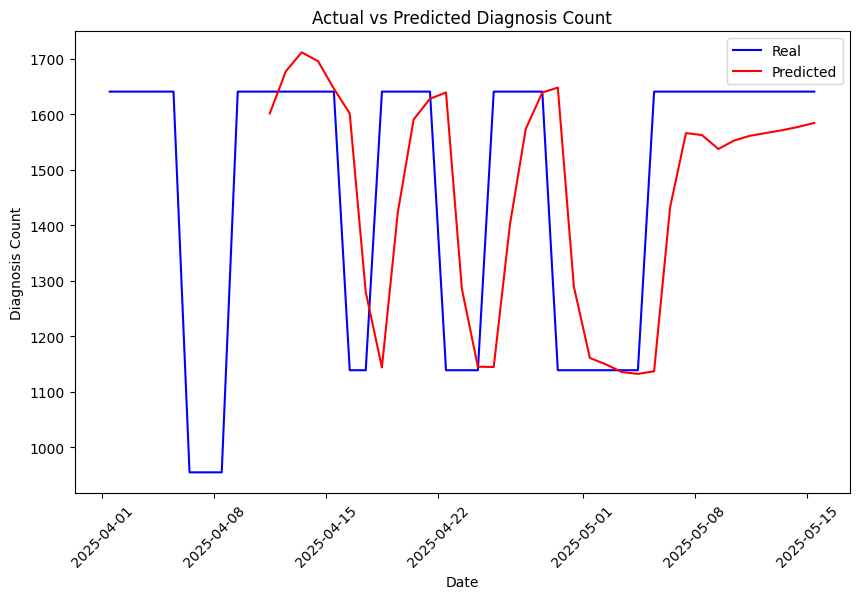

In [13]:
from matplotlib import pyplot as plt

# Visualizing Training and Validation Loss
plt.plot(history_count.history['loss'], label='Training Loss')
plt.plot(history_count.history['val_loss'], label='Validation Loss')
plt.title('Diagnosis count: Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction plots
pred_count = model_count.predict(test_X_count)
plt.figure(figsize=(10, 6))
plt.plot(test_df["diagnosis_count"], label="Real", color='blue')
plt.plot(pd.DataFrame(index=test_df.index[lookback:], data=scaler_output_count.inverse_transform(pred_count)),
         label="Predicted", color='red')
plt.xticks(rotation=45)
plt.title('Actual vs Predicted Diagnosis Count')
plt.xlabel('Date')
plt.ylabel('Diagnosis Count')
plt.legend()
plt.show()

In [17]:
from etl.load.db import engine
from analysis.model.prediction import Prediction

# Save results to database
# Prepare data for saving
timestamps = test_df.index[lookback:]
real_values = test_df["diagnosis_count"].values[lookback:]
predicted_values = scaler_output_count.inverse_transform(pred_count[:len(timestamps)]).flatten()

# Create table if it doesn't exist
Prediction.__table__.create(bind=engine, checkfirst=True)

try:
    # Iterate and save predictions
    for timestamp, real, predicted in zip(timestamps, real_values, predicted_values):
        prediction = Prediction(
            timestamp=timestamp,
            real_diagnosis_count=int(real),
            predicted_diagnosis_count=int(predicted)
        )
        session.add(prediction)

    # Commit the session
    session.commit()
except SQLAlchemyError as e:
    # Rollback in case of error
    session.rollback()
    print("Error occurred while saving predictions.")
finally:
    # Close the session
    session.close()
